In [330]:
#@title

import matplotlib.pyplot as plt
from math import sin, cos, pi, floor
import bisect
import heapq
from typing import List, Dict, Any, Union
import sys
from abc import ABC, abstractmethod
import concurrent
import copy
from termcolor import colored
import textwrap
import itertools

In [331]:
#@title

config0 ='''
#N 3
#D 40          
#V1 P10
#V2
#V3 P1

#E1 1 2 W20
#E2 2 3 W2
'''

config1 ='''
#N 6
#D 400            
#V1 P6
#V2
#V3 P2
#V4
#V5 P7
#V6 P1

#E1 1 2 W4
#E2 2 3 W5
#E3 3 6 W1
#E4 2 4 W3
#E5 4 5 W2
#E6 2 5 W1
'''

config2 ='''
#N 6
#D 40            
#V1 P6
#V2
#V3 P2
#V4
#V5 P7
#V6 P1

#E1 1 2 W4
#E2 2 3 W5
#E3 3 6 W1
#E4 2 4 W3
#E5 4 5 W2
#E6 2 5 W1
'''

config3 ='''
#N 20
#D 4.5             
#V1
#V2 P1
#V3
#V4 P2
#V5
#V6 P1
#V7
#V8 P4
#V9
#V10 P2
#V11 P3
#V12
#V13 P5
#V14 P4
#V15
#V16 P7
#V17 P2
#V18
#V19 P4
#V20 P3

#E1 1 2 W8
#E2 3 4 W8
#E3 2 3 W6
#E4 1 3 W4
#E5 2 4 W5
#E6 3 5 W6
#E7 3 6 W4
#E8 3 9 W7
#E9 4 7 W3
#E10 4 11 W1
#E11 11 15 W5
#E12 7 14 W6
#E13 14 18 W2
#E14 18 19 W3
#E15 12 19 W4
#E16 6 19 W1
#E17 10 13 W5
#E18 10 17 W4
#E19 5 16 W2
#E20 16 17 W3
#E21 17 20 W5
#E22 1 20 W6
#E23 20 5 W2
#E23 20 7 W4
#E24 4 8 W3
#E25 11 7 W2
#E26 12 14 W5
#E27 2 13 W2
#E28 5 14 W4
#E29 8 5 W1
'''

config4 = '''
#N 6
#D 20 
#V1          
#V2 P1            
#V3 P2               
#V4 P4            
#V5 P5

#V7 P6

#E1 1 3 W2  
#E2 1 2 W3           
#E3 3 2 W4  
#E5 1 7 W5
#E7 3 4 W7           
#E8 4 5 W4   

'''

In [332]:
#@title

def parse_config_string(config_string):
  N = 0
  D = 0
  vertices_config = {}
  edges_config = {}

  for line in config_string.split('\n'):
    if len(line):
      identifier = line[1]

      if identifier == 'N':
        N = int(line[3:])
      elif identifier == 'D':
        D = float(line[3:])
      elif identifier == 'V':
        p = 0
        splitted = line[1:].replace('P', '').split(' ')
        if len(splitted) > 1 and len(splitted[1]):
          v, p = splitted[0:2]
        else:
          v = splitted[0]
        vertices_config[v] = int(p)
      else:
        splitted = line[1:].replace('W', '').split(' ')[0:4]
        e, v1_num, v2_num, w = splitted
        v1v2 = sorted([v1_num, v2_num])
        v1_id = 'V' + v1v2[0]
        v2_id = 'V' + v1v2[1]
        edges_config[v1_id + v2_id] = (v1_id, v2_id, int(w))

  return N, D, vertices_config, edges_config

In [333]:
class Vertex:
    def __init__(self, v_id, n_people: int, x: float = None, y: float = None):
      self.v_id = v_id
      self.n_people = n_people
      self.visited = False
      self.x = x
      self.y = y
      self.edges = {}
      self.dist = sys.maxsize
      self.init = ''

    def __lt__(self, other):
      return (self.dist, self.v_id) < (other.dist, other.v_id)
    
    def __str__(self):
      return self.v_id

class Edge:
  def __init__(self, e_id, V1: Vertex, V2: Vertex, w: int):
    self.e_id = e_id
    self.Vs = {V1, V2}
    self.w = w
    self.blocked = False

  def __str__(self):
    return self.e_id

  def __eq__(self, other):
    return self.e_id == other.e_id
    
  def __hash__(self):
    return hash(self.e_id)

  def __lt__(self, other):
    return (self.w, self.e_id) < (other.w, other.e_id)
  
  def get_other_vertex(self, v: Vertex):
    return (self.Vs - {v}).pop()
  
  def get_vertices_ids(self):
    v_id = self.e_id[0:2]
    u_id = self.e_id[2:4]

    return v_id, u_id

class EdgeLocation:
  def __init__(self, e_id, origin_v_id, destination_v_id, units: int):
    self.e_id = e_id
    self.origin_v_id = origin_v_id
    self.destination_v_id = destination_v_id
    self.units = units
  
  def __str__(self):
    return 'Walking on ' + self.e_id + ' to ' + self.destination_v_id \
    + ' with ' + str(self.units) + ' units left'

class Graph:
    def __init__(self, vertices: Dict[Any, Vertex], edges: Dict[Any, Edge]):
      self._vertices = vertices
      self._edges = edges

    def get_vertices(self):
      return self._vertices
    
    def get_edges(self):
      return self._edges

    @staticmethod
    def add_edges_to_vertices(edges):
      for e_id, e in edges.items():
          for v in e.Vs:
            v_edges = v.edges
            if e_id not in v_edges:
              v_edges[e_id] = e

    @classmethod
    def from_config(cls, vertices_config: Dict[str, int], edges_config: Dict[str, tuple]):
        n = len(vertices_config)
        vertices = {v_id: Vertex(v_id, n_people, cos(2 * pi * i / n), sin(2 * pi * i / n))
                         for i, (v_id, n_people) in enumerate(vertices_config.items())}
        edges = {e_id: Edge(e_id, vertices[e_tup[0]], vertices[e_tup[1]], e_tup[2])
                      for e_id, e_tup in edges_config.items()}

        Graph.add_edges_to_vertices(edges)
        
        return cls(vertices, edges)

    def plot(self):
        V_x = []
        V_y = []
        V_x_people = []
        V_y_people = []
        # V_x_init = []
        # V_y_init = []

        fig, ax = plt.subplots(dpi=100)

        for v in self._vertices.values():
          # if v.init:
          #   V_x_init.append(v.x)
          #   V_y_init.append(v.y)
          if v.n_people > 0:
            V_x_people.append(v.x)
            V_y_people.append(v.y)
          else:
            V_x.append(v.x)
            V_y.append(v.y)

          ax.annotate(s=str(v.v_id) + (', p:' + str(v.n_people) if v.n_people > 0 else '') + 
                      (':' + str(v.init) if v.init else ''), xy=(v.x, v.y))

        # ax.scatter(V_x_init, V_y_init, color="g", label='init', s=200)
        ax.scatter(V_x, V_y, color="b", label='shapes', s=200)
        ax.scatter(V_x_people, V_y_people, color="r", label='people', s=200)

        for e in self._edges.values():
            V_x = []
            V_y = []

            w_x = 0
            w_y = 0

            for v in e.Vs:
                V_x.append(v.x)
                V_y.append(v.y)

                w_x += v.x
                w_y += v.y

            ax.plot(V_x, V_y, color="b", linewidth=0.3)
            plt.text(w_x/2, w_y/2, str(e.w))

        ax.tick_params(axis='both', which='both', bottom=False, top=False, 
                       labelbottom=False, right=False, left=False,
                       labelleft=False)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
    
    def Dijkstra(self, v_id):
      vertices = self._vertices

      for v in vertices.values():
          v.dist = sys.maxsize

      vertices[v_id].dist = 0
      Q = list(vertices.values())

      while len(Q):
        heapq.heapify(Q)
        u = heapq.heappop(Q)

        for e in u.edges.values():
            v = e.get_other_vertex(u)

            if v in Q:
                alt = u.dist + e.w
                if alt < v.dist:
                    v.dist = alt
      
    def Kruskal(self) -> int:
      min_spanning_tree_cost = 0
      vertex_sets = {v_id: v_set for v_set, v_id in enumerate(self._vertices.keys())}
      ordered_edges = sorted(self._edges.values())

      for e in ordered_edges:
        e_id = e.e_id
        v_id, u_id = e.get_vertices_ids()
        v_set = vertex_sets[v_id]
        u_set = vertex_sets[u_id]

        if v_set != u_set:
          min_spanning_tree_cost += e.w
          
          for k_id, k_set in vertex_sets.items():
            if k_set == u_set:
              vertex_sets[k_id] = v_set

      return min_spanning_tree_cost
    
    def Prim(self, init_id) -> int:
      vertices = self.get_vertices()
      n = len(vertices)
      init = vertices[init_id]
      forest_vertices_ids = {init_id}
      edges_heap = list(init.edges.values())
      min_spanning_tree_edges = []
      min_spanning_tree_cost = 0

      while len(forest_vertices_ids) < n:
        heapq.heapify(edges_heap)
        e = heapq.heappop(edges_heap)
        v_id, u_id = e.get_vertices_ids()

        if v_id not in forest_vertices_ids:
          k_id = v_id
        elif u_id not in forest_vertices_ids:
          k_id = u_id
        else:
          continue

        edges_heap += list(vertices[k_id].edges.values())

        min_spanning_tree_edges.append(e)
        forest_vertices_ids.add(k_id)
        min_spanning_tree_cost += e.w

      return min_spanning_tree_cost

In [334]:
class Game:
    def __init__(self, D: float, vertices_config: Dict[str, int],
                 edges_config: Dict[str, tuple], agents_config: Dict[Any, Any],
                 tactic: str, cutoff: int = 10, alpha_beta = True):
      self.deadline = D
      self.graph = Graph.from_config(vertices_config, edges_config)
      for agent_id, v_id in agents_config.items():
        self.graph.get_vertices()[v_id].init += ' V0_' + str(agent_id)
        
      init_people = {v_id: (v.n_people if v_id not in agents_config.values() else 0) for v_id, v  in \
                      self.graph.get_vertices().items() if v.n_people > 0}
      init_saved = {agent_id: (self.graph.get_vertices()[init_vertex_id].n_people if init_vertex_id in init_people else 0) 
        for agent_id, init_vertex_id in agents_config.items()}
      self.current_state = State(self, agents_config, init_saved, init_people, 0)
      self.agents = {agent_id: AIGameAgent(agent_id, self, V0_id) for \
                      agent_id, V0_id in agents_config.items()}
      self.time = 0
      self.cutoff = cutoff
      self.tactic = tactic
      self.alpha_beta = alpha_beta
      # self.metric_closure_graph = self.create_metric_closure()

      for v in self.graph.get_vertices().values():
        v.dist = sys.maxsize

    def run_game(self):
      while self.time != self.deadline and self.current_state.any_people_left():
        print('-'*20 + 't = ' + str(self.time) + '-' + str(self.time + 1) + '-'*20)
        current_agent = self.agents[chr(self.time % 2 + ord('A'))]
        print('Currently saved situation: ' + str(self.current_state.saved))
        print('Current people situation: ' + str(self.current_state.people))
        current_agent.act(self.alpha_beta)
        self.time += 1
      
      print('Final people situation: ' + str(self.current_state.people))
      print('People saved: ' + str(self.current_state.saved) + ('\nThe winner is ' + ('A' if 
                                self.current_state.saved['A'] > self.current_state.saved['B'] 
                                else 'B') if self.current_state.saved['A'] != self.current_state.saved['B'] else '\nThere is a tie'))
      print('States created: ' + str(State.states_created))
    
    def create_metric_closure(self):
      graph = self.graph
      vertices = graph.get_vertices()
      terminals = {v_id: Vertex(v_id, v.n_people, v.x, v.y) for v_id, v in 
                          vertices.items()}
      metric_edges = {}

      for v_id, v in terminals.items():
        graph.Dijkstra(v_id)

        for u_id, u in terminals.items():
          if u_id != v_id:
            uv = sorted([v_id[1], u_id[1]])
            e_id = 'V' + uv[0] + 'V' + uv[1]
            
            if e_id not in metric_edges:
              potential_edge = Edge(e_id, u, v, vertices[u_id].dist)
              terminals[v_id].edges[e_id] = potential_edge
              terminals[u_id].edges[e_id] = potential_edge
              metric_edges[e_id] = potential_edge

      metric_closure_graph = Graph(terminals, metric_edges)
      return metric_closure_graph

In [335]:
class State:
  states_created = 0
  def __init__(self, game: Game, 
               locations: Dict[str, Union[Any, EdgeLocation]],
               saved: Dict[str, int], people: Dict[Any, int],
               time: int):
    self.game = game
    self.locations = locations
    self.saved = saved
    self.people = people
    self.time = time
    State.states_created += 1

  def get_heuristic_value(self, agent_id):
    other = AIGameAgent.get_other_player(agent_id)
    h = {agent_id: self.saved[agent_id], other: self.saved[other]}

    if self.game.tactic == 'Adverserial':
      
      # graph = copy.deepcopy(self.game.graph)
      # vertices = graph.get_vertices()

      # other_location = self.game.current_state.locations[other]
      # if not isinstance(other_location, str):
      #   other_location = other_location.origin_v_id

      # current_metric_graph_self = self.get_current_metric_graph(self.locations[agent_id])
      # current_metric_graph_other = self.get_current_metric_graph(self.locations[other])

      # mst_self = current_metric_graph_self.Kruskal()
      # mst_other = current_metric_graph_other.Kruskal()

      # # graph.Dijkstra(self.game.current_state.locations[agent_id])
      # # dij_self = vertices[self.locations[agent_id]].dist

      # # graph.Dijkstra(other_location)
      # # dij_other = vertices[self.locations[other]].dist

      # print('-'*10)
      # print('self: ' + str(self.locations[agent_id]) + ', mst self: ' + str(mst_self) + ', h: ' + str(h[agent_id]))
      # print('other: ' + str(self.locations[other]) + ', mst other: ' + str(mst_other) + ', h: ' + str(h[other]))

      print('-'*10)
      print('self: ' + str(self.locations[agent_id]) + ', h: ' + str(h[agent_id]))
      print('other: ' + str(self.locations[other]) + ', h: ' + str(h[other]))

      # h = h[agent_id] - mst_self - (h[other] - mst_other)

      h = h[agent_id] - h[other]
    elif self.game.tactic == 'Fully Cooperative':
      h = h[agent_id] + h[other]

    return h
  
  def get_vertex_state(self, agent_id, destination_v_id, w: int = 1, hypothetical = False):
    current_locations = self.locations.copy()
    current_locations[agent_id] = destination_v_id
    other_id = AIGameAgent.get_other_player(agent_id)

    if not isinstance(current_locations[other_id], str) and hypothetical:
      current_locations[other_id] = current_locations[other_id].origin_v_id

    currently_saved = self.saved.copy()
    current_people = self.people.copy()

    if destination_v_id in current_people:
      currently_saved[agent_id] = currently_saved[agent_id] + current_people[destination_v_id]
      current_people[destination_v_id] = 0

    current_time = self.time + w

    son = State(self.game, current_locations, currently_saved, 
                current_people, current_time)

    return son
  
  def get_traverse_state(self, e: Edge, agent_id, origin_v_id, destination_v_id):
    e_id = e.e_id
    current_locations = self.locations.copy()
    current_locations[agent_id] = EdgeLocation(e_id, origin_v_id, destination_v_id, e.w - 1)

    son = State(self.game, current_locations, self.saved.copy(), 
                self.people.copy(), self.time + 1)
    
    return son

  def cutoff_test(self, d):

    return d == self.game.cutoff or not self.any_people_left()

  def any_people_left(self):
    return any([n_people > 0 for n_people in self.people.values()])
  
  def get_current_metric_graph(self, v_id):

    def is_edge_valid(e_id, terminal_vals, u_id = None):
      v1_id = e_id[0:2]
      v2_id = e_id[2:4]
      res = {v1_id, v2_id}.issubset(terminal_vals)

      if u_id:
        res = res and u_id in [v1_id, v2_id]

      return res
    
    # v_id = self.current_vertex.v_id
    metric_graph = self.game.metric_closure_graph
    metric_vertices = metric_graph.get_vertices()
    metric_edges = metric_graph.get_edges()
    v = metric_vertices[v_id]
    current_terminals = {u_id: u for u_id, u in metric_vertices.items()
                          if u_id in self.people and self.people[u_id] > 0}
    if v_id not in current_terminals:
      current_terminals[v_id] = v
    terminal_vals = set(current_terminals.keys())

    for u in current_terminals.values():
      u_id = u.v_id
      u.edges = {e_id: e for e_id, e in metric_edges.items() if 
                 is_edge_valid(e_id, terminal_vals, u_id)}

    current_metric_edges = {e_id: e for e_id, e in 
                            metric_edges.items() 
                            if is_edge_valid(e_id, terminal_vals)}

    current_metric_graph = Graph(current_terminals, current_metric_edges)
    # current_metric_graph.plot()
    return current_metric_graph

In [336]:
class AIGameAgent:
    def __init__(self, agent_id, game: Game, V0_id):
      self.agent_id = agent_id
      self.game = game
      self.game.current_state.locations[self.agent_id] = V0_id

    def act(self, alpha_beta):
      current_location = self.game.current_state.locations[self.agent_id]
      print('Before: ' + str(self.agent_id) + ': ' + str(current_location))
      if isinstance(current_location, str): # vertex
        chosen_edge, chosed_u_id = self.alpha_beta_minmax_decision(alpha_beta) \
          if self.game.tactic == 'Adverserial' else self.cooperative_decision()
        if chosen_edge.w == 1:
          self.game.current_state = self.game.current_state.get_vertex_state(self.agent_id, chosed_u_id)
        else:
          self.game.current_state = self.game.current_state.get_traverse_state(chosen_edge, self.agent_id, current_location, chosed_u_id)
      elif current_location.units == 1:
          current_location = current_location.destination_v_id
          self.game.current_state = self.game.current_state.get_vertex_state(self.agent_id, current_location)
      else:
        current_location.units -= 1
      print('After: ' + str(self.agent_id) + ': ' + str(self.game.current_state.locations[self.agent_id]))

    def alpha_beta_minmax_decision(self, alpha_beta = True):
      current_state = self.game.current_state
      locations = current_state.locations
      saved = current_state.saved
      v_id = locations[self.agent_id]
      v = self.game.graph.get_vertices()[v_id]

      max_value = - sys.maxsize
      chosen_edge = None
      chosed_u_id = None

      if alpha_beta:
        alpha = - sys.maxsize
        beta = sys.maxsize

      for i, e in enumerate(v.edges.values()):
        u = e.get_other_vertex(v)
        u_id = u.v_id

        if i == 0:
            chosen_edge = e
            chosed_u_id = u_id
        current_son = current_state.get_vertex_state(self.agent_id, u_id, e.w, True)

        if current_son.time < self.game.deadline:
          if alpha_beta:
            current_min_value = self.min_value(current_son, 1, alpha , beta)
            if current_min_value >= beta:
              return chosen_edge, chosed_u_id
            alpha = max(alpha, current_min_value)
          else:
            current_min_value = self.min_value(current_son, 1)
          if current_min_value > max_value:
            max_value = current_min_value
            chosen_edge = e
            chosed_u_id = u_id

      return chosen_edge, chosed_u_id
 
    def max_value(self, s: State, d: int, alpha: int = None, beta: int= None):
      if s.cutoff_test(d):
        return s.get_heuristic_value(self.agent_id)

      value = - sys.maxsize
      locations = s.locations
      v_id = locations[self.agent_id]
      v = self.game.graph.get_vertices()[v_id]

      for e in v.edges.values():
        u = e.get_other_vertex(v)
        u_id = u.v_id
        current_son = s.get_vertex_state(self.agent_id, u_id, e.w, True)

        if current_son.time < self.game.deadline:
          if alpha is not None and beta is not None:
            value = max(value, self.min_value(current_son, d+1, alpha, beta))
            if value >= beta:
              # print('Pruned: alpha: ' + str(alpha) + ', beta: ' + str(beta))
              return value
            alpha = max(alpha, value)
          else:
            value = max(value, self.min_value(current_son, d+1))
      # print('Final: alpha: ' + str(alpha) + ', Final beta: ' + str(beta))
      return value
    
    def min_value(self, s: State, d: int, alpha: int = None, beta: int = None):
      other = AIGameAgent.get_other_player(self.agent_id)

      if s.cutoff_test(d):
        return s.get_heuristic_value(self.agent_id)

      value = sys.maxsize

      locations = s.locations
      v_id = locations[other]
      v = self.game.graph.get_vertices()[v_id]

      for e in v.edges.values():
        u = e.get_other_vertex(v)
        u_id = u.v_id
        current_son = s.get_vertex_state(other, u_id, e.w, True)
        if current_son.time < self.game.deadline:
          if alpha is not None and beta is not None:
            value = min(value, self.max_value(current_son, d+1, alpha, beta))
            if value <= alpha:
              # print('Pruned: alpha: ' + str(alpha) + ', beta: ' + str(beta))
              return value
            beta = min(beta, value)
          else:
            value = min(value, self.max_value(current_son, d+1))
      
      # print('Final: alpha: ' + str(alpha) + ', Final beta: ' + str(beta))
      return value
    
    def cooperative_decision(self):
      current_state = self.game.current_state
      locations = current_state.locations
      saved = current_state.saved
      v_id = locations[self.agent_id]
      v = self.game.graph.get_vertices()[v_id]
      other = AIGameAgent.get_other_player(self.agent_id)
      
      max_value = - sys.maxsize if self.game.tactic != 'Semi Cooperative' else \
        {self.agent_id: - sys.maxsize, other: - sys.maxsize}
      chosen_edge = None
      chosed_u_id = None

      for i, e in enumerate(v.edges.values()):
        u = e.get_other_vertex(v)
        u_id = u.v_id

        if i == 0:
            chosen_edge = e
            chosed_u_id = u_id
        current_son = current_state.get_vertex_state(self.agent_id, u_id, e.w, True)

        if current_son.time < self.game.deadline:
          potential = self.max_cooperative_value(current_son, 1, other)

          if self.game.tactic == 'Semi Cooperative':
            potential_tup = (potential[self.agent_id], potential[other])
            max_tup = (max_value[self.agent_id], max_value[other])
          else:
            potential_tup = potential
            max_tup = max_value
          if potential_tup > max_tup:
            max_value = potential
            chosen_edge = e
            chosed_u_id = u_id

      return chosen_edge, chosed_u_id

    def max_cooperative_value(self, s: State, d: int, current_agent_id):
      if s.cutoff_test(d):
        return s.get_heuristic_value(self.agent_id)

      other = AIGameAgent.get_other_player(current_agent_id)
      value = - sys.maxsize if self.game.tactic != 'Semi Cooperative' else \
        {current_agent_id: - sys.maxsize, other: - sys.maxsize}

      locations = s.locations
      v_id = locations[current_agent_id]
      v = self.game.graph.get_vertices()[v_id]

      for e in v.edges.values():
        u = e.get_other_vertex(v)
        u_id = u.v_id
        current_son = s.get_vertex_state(current_agent_id, u_id, e.w, True)

        if current_son.time < self.game.deadline:
          potential = self.max_cooperative_value(current_son, d+1, other)

          if self.game.tactic == 'Semi Cooperative':
            pot_h_self = potential[current_agent_id]
            pot_h_other = potential[other]
            curr_h_self = value[current_agent_id]
            curr_h_other = value[other]

            if (pot_h_self, pot_h_other) > (curr_h_self, curr_h_other):
              value = potential
          else:
            value = max(value, potential)
      return value

    @staticmethod
    def get_other_player(agent_id):
      return 'A' if agent_id == 'B' else 'B'

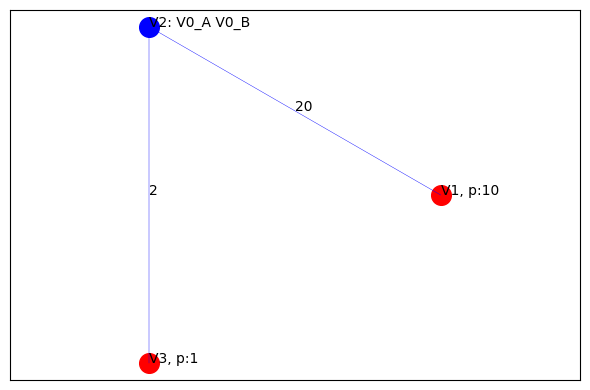

--------------------t = 0-1--------------------
Currently saved situation: {'A': 0, 'B': 0}
Current people situation: {'V1': 10, 'V3': 1}
Before: A: V2
----------
self: V1, h: 10
other: V3, h: 1
----------
self: V3, h: 1
other: V1, h: 10
----------
self: V3, h: 1
other: V3, h: 0
After: A: Walking on V1V2 to V1 with 19 units left
--------------------t = 1-2--------------------
Currently saved situation: {'A': 0, 'B': 0}
Current people situation: {'V1': 10, 'V3': 1}
Before: B: V2
----------
self: V1, h: 10
other: V3, h: 1
----------
self: V3, h: 1
other: V1, h: 10
----------
self: V3, h: 1
other: V3, h: 0
After: B: Walking on V1V2 to V1 with 19 units left
--------------------t = 2-3--------------------
Currently saved situation: {'A': 0, 'B': 0}
Current people situation: {'V1': 10, 'V3': 1}
Before: A: Walking on V1V2 to V1 with 19 units left
After: A: Walking on V1V2 to V1 with 18 units left
--------------------t = 3-4--------------------
Currently saved situation: {'A': 0, 'B': 0}
Curre

In [337]:
def run_simulation(config):
  N, D, vertices_config, edges_config = parse_config_string(config)
  n = len(vertices_config)
  
  # for i in range(1, n + 1):
  # v0 = 'V' + str(i)
  # print(colored('-' * 60 + ' V0 = V' + str(i) + " " + '-' * 60, 'green'))
  # for tactic in ['Adverserial', 'Semi Cooperative', 'Fully Cooperative']:
  alpha_beta = False
  cutoff = 2
  agents_config = {'A': 'V2', 'B': 'V2'}
  game = Game(D, vertices_config, edges_config, agents_config, 'Adverserial', cutoff, alpha_beta)
  # if i == 1:
  game.graph.plot()
  game.run_game()

if __name__ == '__main__':
    run_simulation(config0)